In [ ]:
!pip install faker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.8 MB/s eta 0:00:00


Create dummy data for the Hospital

In [ ]:
# Import the required libraries
import pandas as pd
import random
from faker import Faker
from datetime import datetime, timedelta

# Initialize Faker
fake = Faker()

# Number of records to generate
n = 1000

# Asset Types for a hospital
asset_types = ['MRI Machine', 'CT Scanner', 'Ultrasound Machine', 'Ventilator', 'Hospital Bed', 'Defibrillator', 'Infusion Pump', 'ECG Machine', 'Anesthesia Machine', 'Operating Table']

# Manufacturers
manufacturers = ['Manufacturer_A', 'Manufacturer_B', 'Manufacturer_C', 'Manufacturer_D']

# Floors in the hospital
floors = list(range(1, 11))  # Assuming the hospital has 10 floors

# Departments in the hospital
departments = ['Emergency', 'ICU', 'Pediatrics', 'Surgery', 'Cardiology', 'Orthopedics', 'Radiology', 'Laboratory', 'Pharmacy', 'Admin']

# Create an empty DataFrame to store the asset data
df = pd.DataFrame(columns=['Asset ID', 'Asset Type', 'Floor', 'Department', 'Installation Date', 'Manufacturer', 'Operational Time (hrs)', 'Work Orders', 'Repairs', 'Last Serviced Date'])

# Populate the DataFrame with simulated data
for i in range(1, n + 1):
    asset_id = i
    asset_type = random.choice(asset_types)
    floor = random.choice(floors)
    department = random.choice(departments)
    installation_date = fake.date_between(start_date='-5y', end_date='today')
    manufacturer = random.choice(manufacturers)
    operational_time = random.randint(50, 20000)  # Adjusted operational time for hospital assets
    work_orders = random.randint(0, 10)
    repairs = random.randint(0, 5)
    last_serviced_date = fake.date_between(start_date=installation_date, end_date='today')

    df.loc[i - 1] = [asset_id, asset_type, floor, department, installation_date, manufacturer, operational_time, work_orders, repairs, last_serviced_date]

# Save the DataFrame to a CSV file
df.to_csv('hospital_assets.csv', index=False)


Identify Realtime Anomalies

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


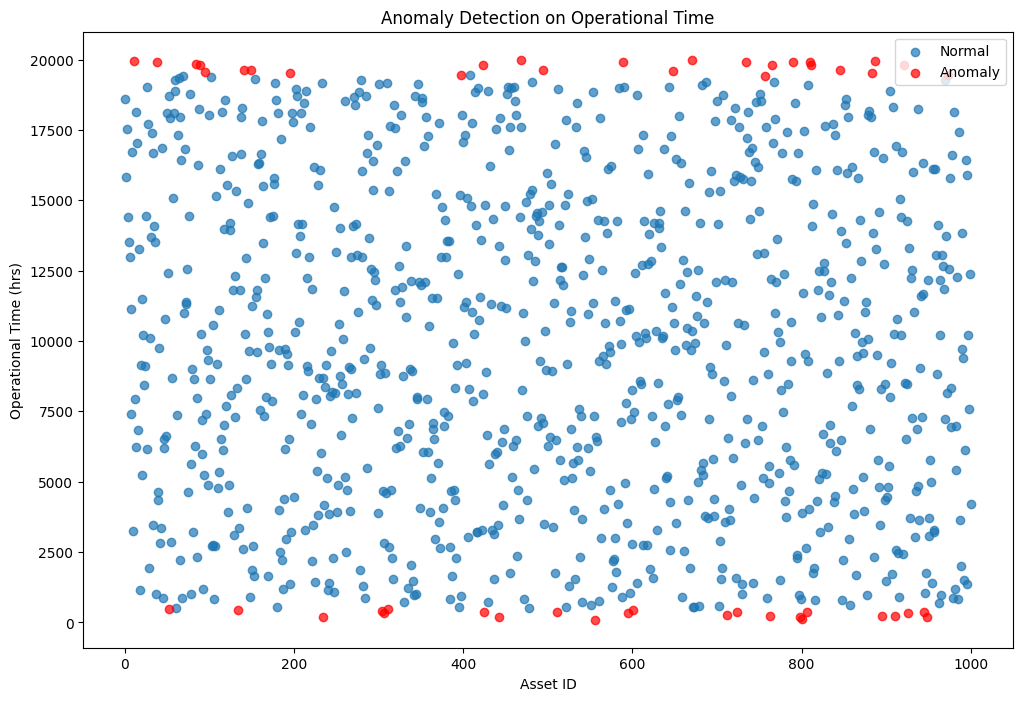

Anomalies in Operational Time:
     Asset ID  Operational Time (hrs)          Asset Type
10         11                   19953          Ventilator
37         38                   19916  Ultrasound Machine
51         52                     492  Anesthesia Machine
83         84                   19842          CT Scanner
88         89                   19820          CT Scanner
94         95                   19564       Defibrillator
133       134                     430         ECG Machine
140       141                   19640  Ultrasound Machine
148       149                   19638         MRI Machine
194       195                   19509         ECG Machine
233       234                     189          CT Scanner
303       304                     415         MRI Machine
306       307                     332  Anesthesia Machine
310       311                     493          CT Scanner
396       397                   19444          CT Scanner
422       423                   19822  An

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Read the generated CSV file into a DataFrame
df = pd.read_csv('hospital_assets.csv')

# Using Isolation Forest for anomaly detection on 'Operational Time (hrs)'
isolation_forest = IsolationForest(n_estimators=100, contamination=0.05)
df['Anomaly_OperationalTime'] = isolation_forest.fit_predict(df[['Operational Time (hrs)']])

# Separate the anomalies from the normal data
anomalies = df[df['Anomaly_OperationalTime'] == -1]
normal = df[df['Anomaly_OperationalTime'] == 1]

# Plotting the results
plt.figure(figsize=(12, 8))
plt.scatter(normal['Asset ID'], normal['Operational Time (hrs)'], label='Normal', alpha=0.7)
plt.scatter(anomalies['Asset ID'], anomalies['Operational Time (hrs)'], label='Anomaly', c='r', alpha=0.7)
plt.xlabel('Asset ID')
plt.ylabel('Operational Time (hrs)')
plt.title('Anomaly Detection on Operational Time')
plt.legend()
plt.show()

# Display anomalies
print("Anomalies in Operational Time:")
print(anomalies[['Asset ID', 'Operational Time (hrs)', 'Asset Type']])


Create the ARIMA model

                                 SARIMAX Results                                  
Dep. Variable:     Operational Time (hrs)   No. Observations:                 1000
Model:                     ARIMA(5, 1, 0)   Log Likelihood              -10136.359
Date:                    Sun, 17 Sep 2023   AIC                          20284.719
Time:                            06:19:55   BIC                          20314.159
Sample:                                 0   HQIC                         20295.909
                                   - 1000                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8832      0.031    -28.422      0.000      -0.944      -0.822
ar.L2         -0.7052      0.040    -17.772      0.000      -0.783      -0.627
ar.L3         -0.554

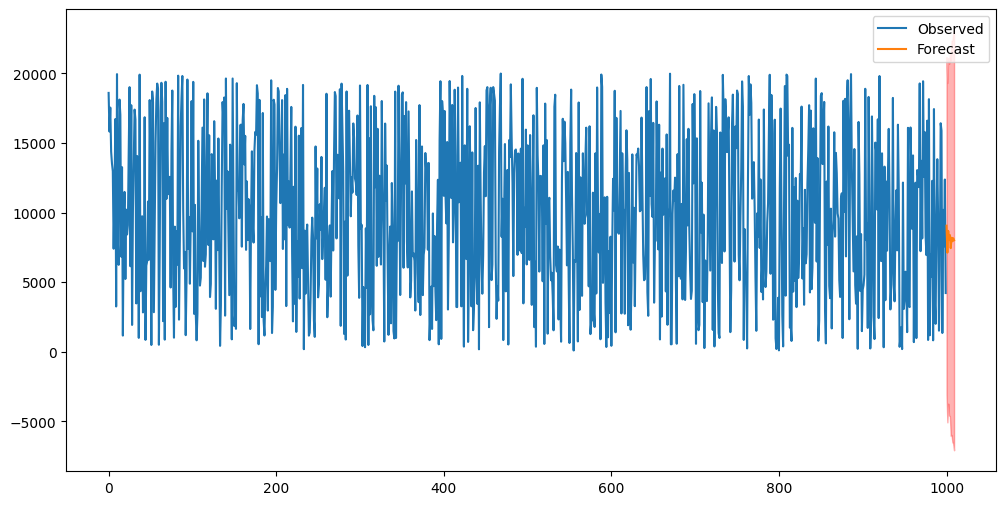

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Create a time series from operational time data
time_series_data = df['Operational Time (hrs)']

# Fit the new ARIMA model
model = ARIMA(time_series_data, order=(5, 1, 0))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Make sure to import matplotlib.pyplot
import matplotlib.pyplot as plt

# Make forecast
future_steps = 10  # Number of steps to predict into the future
forecast_obj = model_fit.get_forecast(steps=future_steps)
forecast = forecast_obj.predicted_mean
stderr = forecast_obj.se_mean
conf_int = forecast_obj.conf_int(alpha=0.05)  # 95% conf

# Generate a new index for the forecast period
new_index = range(len(time_series_data), len(time_series_data) + future_steps)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index, time_series_data, label='Observed')
plt.plot(new_index, forecast, label='Forecast')
plt.fill_between(new_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='r', alpha=0.3)
plt.legend()
plt.show()



Create Failure Probability Calculation

In [ ]:
import pandas as pd

df = pd.read_csv('hospital_assets.csv')

X = df[['Operational Time (hrs)', 'Repairs']]

from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

# Recheck the condition you use to define 'y'.
# For example, you can print out the value counts to see the distribution.
print((df['Repairs'] > 5).value_counts())

# If the condition isn't providing a mix of True and False values,
y = df['Repairs'] > 2  # Adjust this condition according to your needs

# Then you can proceed to fit the model as before:
model.fit(X, y)

# Add the prediction to the DataFrame
df['Failure_Probability'] = model.predict_proba(X)[:, 1]

# Add a 'Predicted_Failure_Next_Month' column
threshold = 0.8
df['Predicted_Failure_Next_Month'] = (df['Failure_Probability'] > threshold).astype(int)

# Save to new CSV
df.to_csv('hospital_assets_with_predictions.csv', index=False)


False    1000
Name: Repairs, dtype: int64


In [ ]:
import pandas as pd

df = pd.read_csv('hospital_assets_with_predictions.csv')
column_name = 'Predicted_Failure_Next_Month'  # Replace with the column name you are interested in

count_1 = (df[column_name] == 1).sum()
count_0 = (df[column_name] == 0).sum()

print(f"Count of 1's in {column_name}: {count_1}")
print(f"Count of 0's in {column_name}: {count_0}")

Count of 1's in Predicted_Failure_Next_Month: 477
Count of 0's in Predicted_Failure_Next_Month: 523


Create graphs to analyze the data

Asset Type
Defibrillator      0.566038
CT Scanner         0.529412
Hospital Bed       0.504505
Ventilator         0.483516
Operating Table    0.471698
Name: Predicted_Failure_Next_Month, dtype: float64




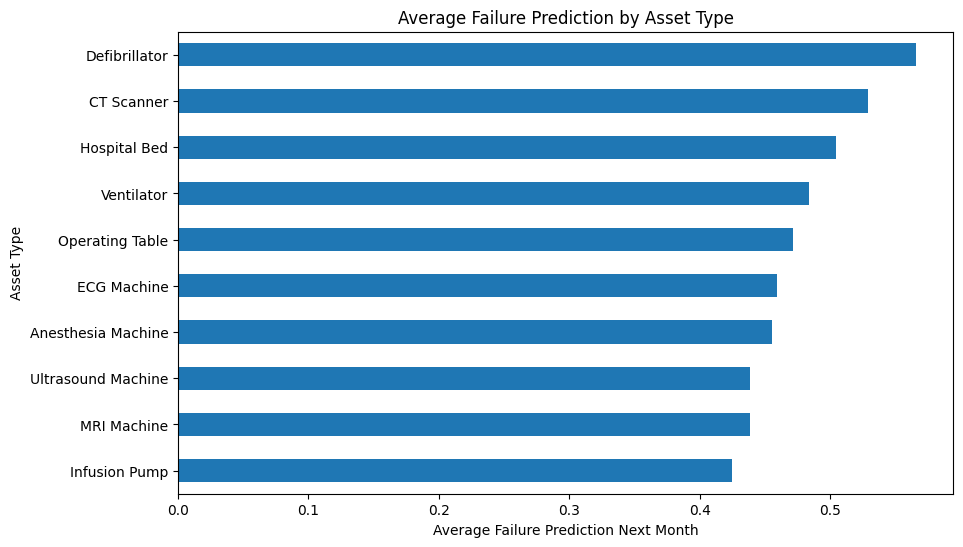

Manufacturer
Manufacturer_A    0.502146
Manufacturer_B    0.487705
Manufacturer_D    0.478088
Manufacturer_C    0.444853
Name: Predicted_Failure_Next_Month, dtype: float64




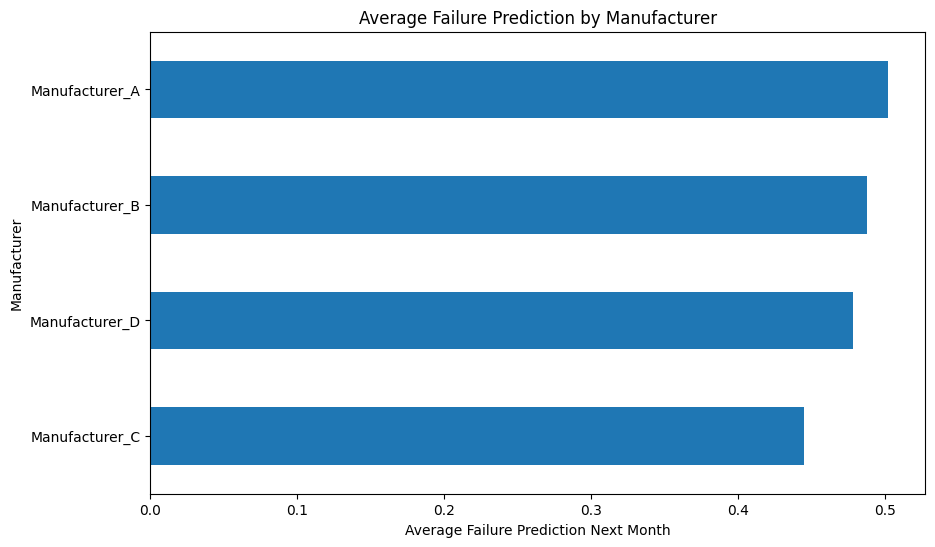

Floor
1    0.570000
7    0.547170
3    0.495575
5    0.486239
2    0.483146
Name: Predicted_Failure_Next_Month, dtype: float64




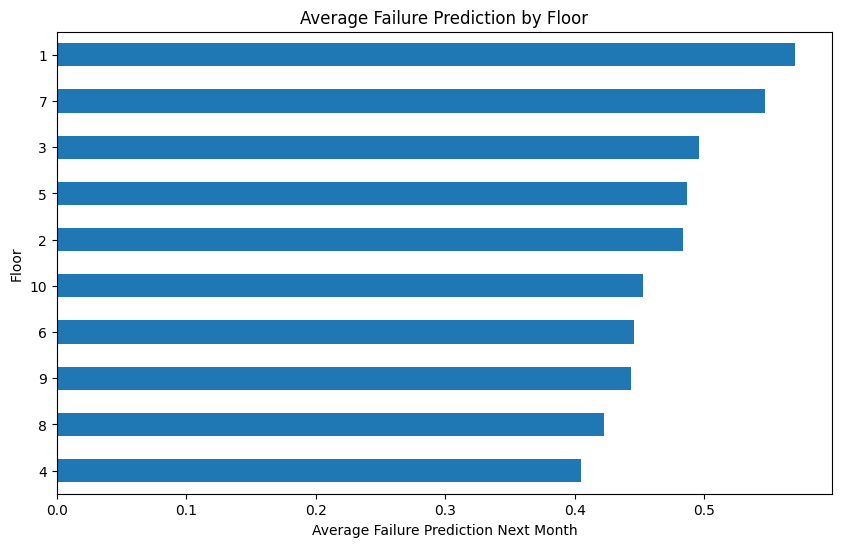

Asset Type
Defibrillator         60
Hospital Bed          56
Operating Table       50
Anesthesia Machine    46
CT Scanner            45
dtype: int64




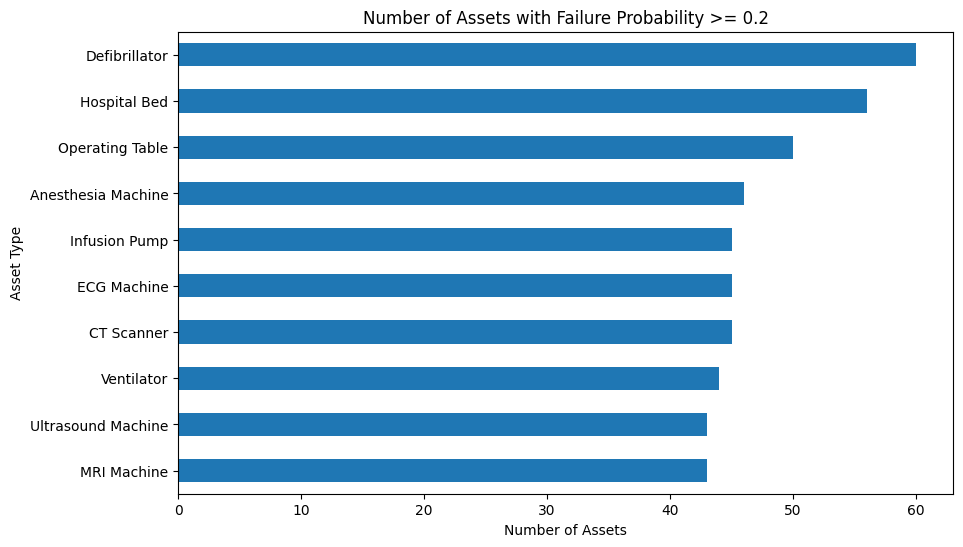

Asset Type
Defibrillator         60
Hospital Bed          56
Operating Table       50
Anesthesia Machine    46
CT Scanner            45
dtype: int64




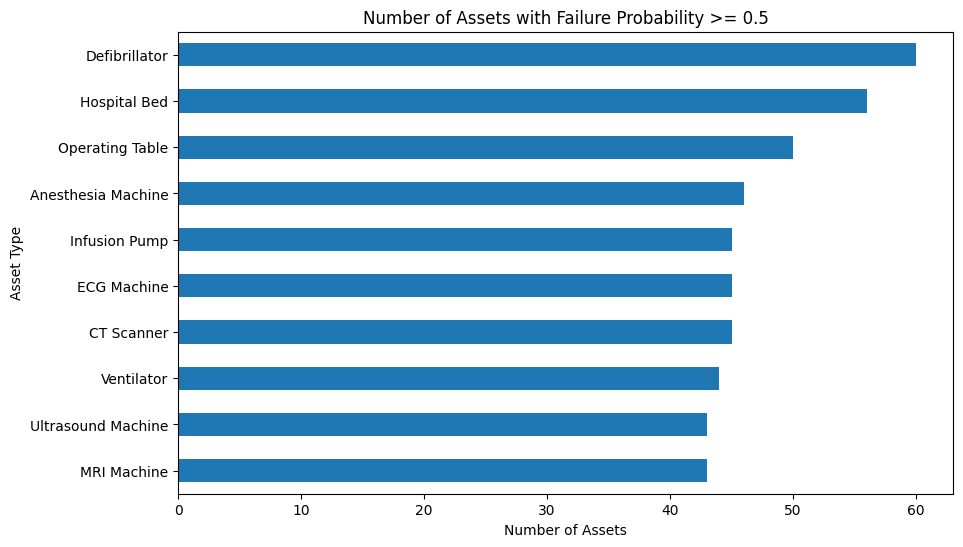

Asset Type
Defibrillator         60
Hospital Bed          56
Operating Table       50
Anesthesia Machine    46
CT Scanner            45
dtype: int64




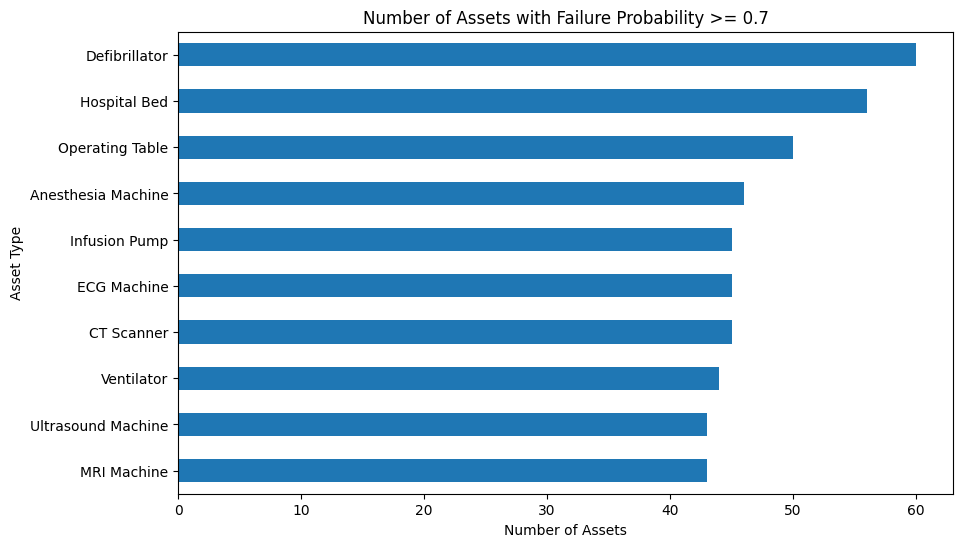

Asset Type
Defibrillator         60
Hospital Bed          56
Operating Table       50
Anesthesia Machine    46
CT Scanner            45
dtype: int64




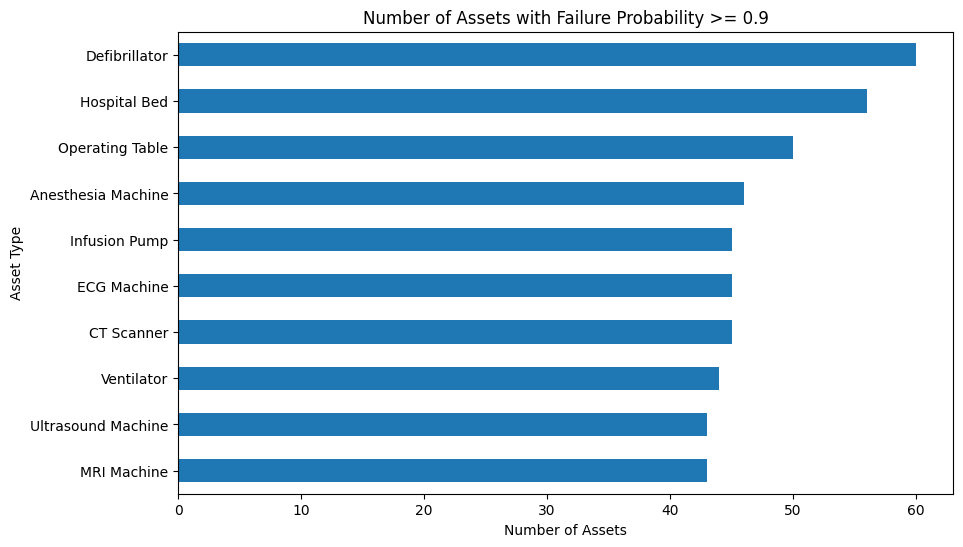

Installation Year
2022    205
2021    201
2019    200
2020    191
2023    132
dtype: int64




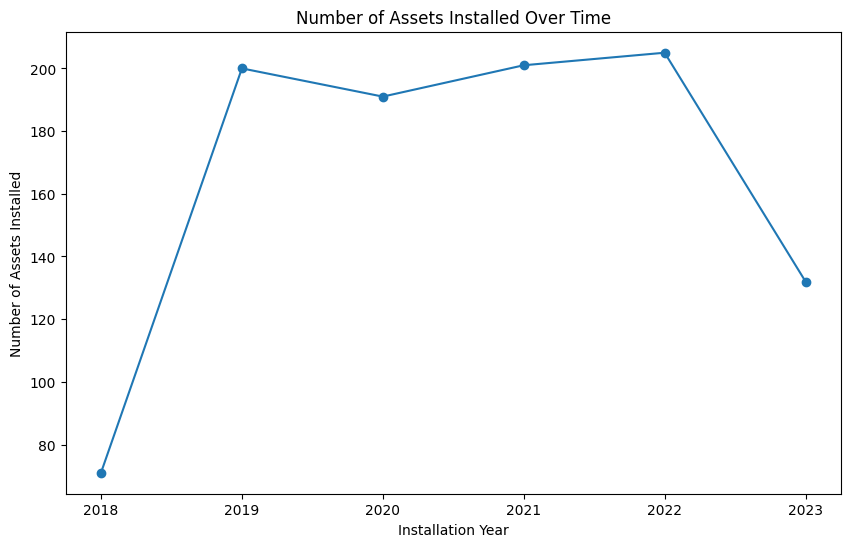

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('hospital_assets_with_predictions.csv')

# Convert dates to pandas datetime objects
df['Installation Date'] = pd.to_datetime(df['Installation Date'])
df['Last Serviced Date'] = pd.to_datetime(df['Last Serviced Date'])

def print_top_values(grouped_data, top_n=5):
    sorted_data = grouped_data.sort_values(ascending=False)
    print(sorted_data.head(top_n))
    print("\n")

# Failure analysis by Asset Type
plt.figure(figsize=(10, 6))
asset_type_group = df.groupby('Asset Type')['Predicted_Failure_Next_Month'].mean()
asset_type_group.sort_values().plot(kind='barh')
plt.xlabel('Average Failure Prediction Next Month')
plt.title('Average Failure Prediction by Asset Type')
print_top_values(asset_type_group)
plt.show()

# Failure analysis by Manufacturer
plt.figure(figsize=(10, 6))
manufacturer_group = df.groupby('Manufacturer')['Predicted_Failure_Next_Month'].mean()
manufacturer_group.sort_values().plot(kind='barh')
plt.xlabel('Average Failure Prediction Next Month')
plt.title('Average Failure Prediction by Manufacturer')
print_top_values(manufacturer_group)
plt.show()

# Failure analysis by Floor
plt.figure(figsize=(10, 6))
floor_group = df.groupby('Floor')['Predicted_Failure_Next_Month'].mean()
floor_group.sort_values().plot(kind='barh')
plt.xlabel('Average Failure Prediction Next Month')
plt.title('Average Failure Prediction by Floor')
print_top_values(floor_group)
plt.show()

# Dynamic threshold analysis for Failure Probability
thresholds = [0.2, 0.5, 0.7, 0.9]
for threshold in thresholds:
    plt.figure(figsize=(10, 6))
    df_high_risk = df[df['Failure_Probability'] >= threshold]
    asset_type_high_risk_group = df_high_risk.groupby('Asset Type').size()
    asset_type_high_risk_group.sort_values().plot(kind='barh')
    plt.xlabel('Number of Assets')
    plt.title(f'Number of Assets with Failure Probability >= {threshold}')
    print_top_values(asset_type_high_risk_group)
    plt.show()

# Time analysis for installations and last service
plt.figure(figsize=(10, 6))
df['Installation Year'] = df['Installation Date'].dt.year
installation_year_group = df.groupby('Installation Year').size()
installation_year_group.plot(kind='line', marker='o')
plt.xlabel('Installation Year')
plt.ylabel('Number of Assets Installed')
plt.title('Number of Assets Installed Over Time')
print_top_values(installation_year_group)
plt.show()


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('hospital_assets_with_predictions.csv')

# Convert dates to pandas datetime objects
df['Installation Date'] = pd.to_datetime(df['Installation Date'])
df['Last Serviced Date'] = pd.to_datetime(df['Last Serviced Date'])

# Create a scoring function for urgency. The weightage can be adjusted.
# Let's assume 'Failure_Probability' ranges from 0 to 1
df['Urgency_Score'] = (df['Failure_Probability'] * 0.6) + (df['Work Orders'] * 0.2) + (df['Repairs'] * 0.2)

# Sort the DataFrame based on the urgency score
df_sorted = df.sort_values('Urgency_Score', ascending=False)

# Take the top 5 assets that need urgent fixing
top_5_urgent_assets = df_sorted.head(5)

print("Top 5 Assets That Need Fixing ASAP:")
print(top_5_urgent_assets[['Asset ID', 'Asset Type', 'Manufacturer', 'Floor', 'Urgency_Score']])


Top 5 Assets That Need Fixing ASAP:
     Asset ID          Asset Type    Manufacturer  Floor  Urgency_Score
995       996          Ventilator  Manufacturer_D      1            3.6
626       627        Hospital Bed  Manufacturer_B     10            3.6
998       999       Infusion Pump  Manufacturer_A     10            3.6
746       747        Hospital Bed  Manufacturer_B      9            3.6
655       656  Anesthesia Machine  Manufacturer_A      8            3.6


In [ ]:
!pip install pandas

In [ ]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('data.csv')

# Sort the DataFrame by the 'Failure_Probability' column from highest to lowest
sorted_df = df.sort_values('Failure_Probability', ascending=False)

# Save the sorted DataFrame back to a new CSV file
sorted_df.to_csv('sorted_file.csv', index=False)

# To download the sorted file if running on Google Colab
from google.colab import files
files.download('sorted_file.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>